<a href="https://colab.research.google.com/github/flowergum/My_colorization/blob/main/Color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Восстановление цвета чёрно-белых изображений

### Импорты и настройки

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, \
                                    Dense, \
                                    MaxPool2D,\
                                    Dropout, \
                                    Flatten, \
                                    BatchNormalization, InputLayer, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from google.colab import files
from io import BytesIO
import glob
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import tensorflow as tf
import tensorboard as tb
import torch
import math
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import RNN, LSTM
import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from tqdm.notebook import tqdm
from torch.nn import init
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Загрузка датасета

In [4]:
#скачиваем и распаковываем .zip файл с изображениями для train, делать 1 раз
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/train.zip', 'r')
img = z.extractall()

In [6]:
#скачиваем и распаковываем .zip файл с изображениями для test, делать 1 раз
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/test.zip', 'r')
img = z.extractall()

In [7]:
#Посчитанные отдельно среднее значение и стандартное отклонение
mean_a = -1.1600414744678562
std_a = 8.186355078077268
mean_b = 0.13165360980751917
std_b = 16.993361951392266

### Создание генератора датасета

In [8]:
def batch_gen(path):
    fileList = os.listdir(path)
    for filepath in fileList:
        img = cv2.imread(path + "/" + filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # processed image
        image = Image.fromarray(np.uint8(img)).resize((128, 128))
        image = np.array(image, dtype=float)
        lab = rgb2lab(1.0/255*image)
        X, Y = lab[:,:,0], lab[:,:,1:]
        Y[:,:,0] = (Y[:,:,0] - mean_a) / std_a
        Y[:,:,1] = (Y[:,:,1] - mean_b) / std_b
        X = X.reshape(image.shape[0], image.shape[1], 1)
        Y = Y.reshape(image.shape[0], image.shape[1], 2)
        yield X, Y                                    

def dataset_gen(path, epochs, batch_size):
    dataset = tf.data.Dataset.from_generator(lambda: batch_gen(path),
                                             output_types=(tf.float64, tf.float64))  #тут формируем датасет
    dataset = dataset.repeat(epochs)          #повторяем датасет нужное число раз; н-р, epochs = 2: [1, 2, 3] --> [1, 2, 3, 1, 2, 3]
    dataset = dataset.batch(batch_size)       #формирует пакеты по batch_size штук в каждом
    return dataset


### Создание тестовой выборки

In [9]:
def processed_image(img):    
  img = np.array(img, dtype=float)
  image = Image.fromarray(np.uint8(img)).resize((128, 128))
  image = np.array(image, dtype=float)   
  size = image.shape
  lab = rgb2lab(1.0/255*image)                
  X, Y = lab[:,:,0], lab[:,:,1:]    
            
  Y[:,:,0] = (Y[:,:,0] - mean_a) / std_a
  Y[:,:,1] = (Y[:,:,1] - mean_b) / std_b  


  X = X.reshape(size[0], size[1], 1)
  Y = Y.reshape(size[0], size[1], 2)
  del size
  return X, Y

In [11]:
import cv2
list_x = []
list_y = []
j = 0
#путь к папке с распакованными изображениями
path = '/content/test'
fileList = os.listdir(path)
for i in fileList:
   file_ = cv2.imread(('/content/test/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   X, Y = processed_image(file_)
   if X.shape == (128, 128, 1) and Y.shape == (128, 128, 2):
      list_x.append(X)
      list_y.append(Y)
   else:
      print('Size')
   j += 1
   if j > 7000:
      break

list_x = np.array(list_x)
list_y = np.array(list_y)
print(list_x.shape, list_y.shape)

(1436, 128, 128, 1) (1436, 128, 128, 2)


### Создание модели

In [12]:
model = Sequential()                                                      # Последовательная
model.add(InputLayer(input_shape=(None, None, 1)))                        # Входной слой, подаем на вход яркостную компоненту
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))          # Свертка, 64 фильтра
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 256)   295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 256)   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 512)   1

### Обучение сети

In [ ]:
#model.load_weights("drive/MyDrive/Colorization/weights/Landscapes_20_epochs.h5")     #если нужно подгрузить уже имеющиеся результаты

In [14]:
train_path = '/content/train'
test_path = '/content/test'

epochs = 15
batch_size = 256
total_items = len(os.listdir(train_path))
num_batches = int(total_items/batch_size)
print(f"batch_size={batch_size}\nnum_batches = {num_batches}\ntotal_samples={num_batches*batch_size}\n{'-'*30}")

dataset = dataset_gen(train_path, epochs, batch_size)

history = model.fit(dataset, steps_per_epoch=num_batches, epochs=epochs, validation_data=(list_x, list_y), verbose=1)

batch_size=256
num_batches = 27
total_samples=6912
------------------------------
Epoch 1/15
27/27 [==============================] - 107s 2s/step - loss: 1.9336 - val_loss: 1.8154
Epoch 2/15
27/27 [==============================] - 61s 2s/step - loss: 1.7779 - val_loss: 1.5982
Epoch 3/15
27/27 [==============================] - 60s 2s/step - loss: 1.5898 - val_loss: 1.5978
Epoch 4/15
27/27 [==============================] - 61s 2s/step - loss: 1.3841 - val_loss: 1.0525
Epoch 5/15
27/27 [==============================] - 61s 2s/step - loss: 1.0413 - val_loss: 0.9587
Epoch 6/15
27/27 [==============================] - 61s 2s/step - loss: 0.9752 - val_loss: 0.9322
Epoch 7/15
27/27 [==============================] - 61s 2s/step - loss: 0.9563 - val_loss: 0.9280
Epoch 8/15
27/27 [==============================] - 61s 2s/step - loss: 0.9309 - val_loss: 0.9513
Epoch 9/15
27/27 [==============================] - 61s 2s/step - loss: 0.9598 - val_loss: 0.8962
Epoch 10/15
27/27 [================

In [15]:
model.save_weights("drive/MyDrive/Colorization/weights/Landscapes_15_epochs.h5")

#### График

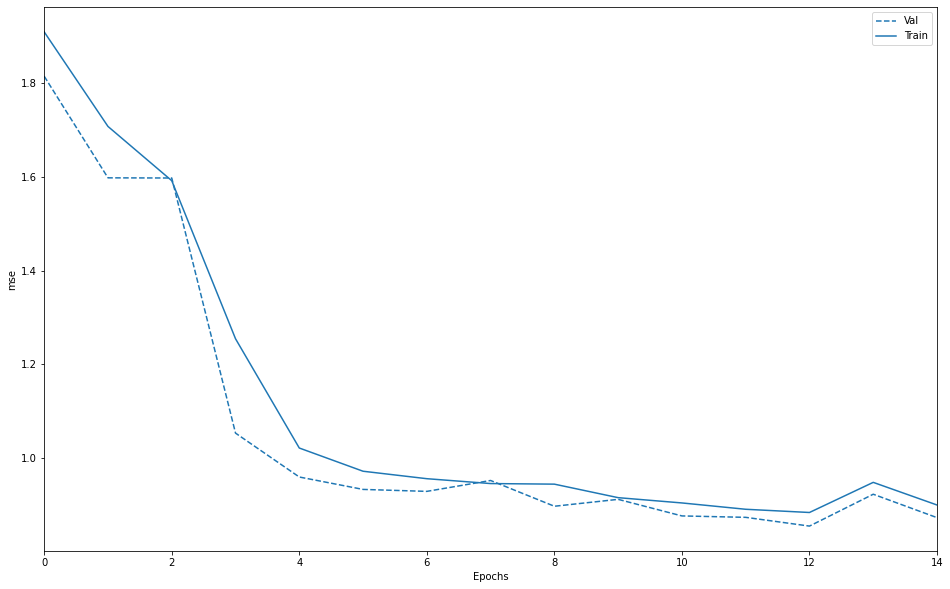

In [16]:
plt.figure(figsize=(16,10))
plt.xlabel('Epochs')
plt.ylabel("mse")
val = plt.plot(history.epoch, history.history['val_'+'loss'],
                   '--', label='Val')
plt.plot(history.epoch, history.history["loss"], color=val[0].get_color(),
             label='Train')
plt.legend()
plt.xlim([0, max(history.epoch)])
plt.savefig('/content/drive/MyDrive/Colorization/graphs/Landscapes_15_epochs.png')

#### Обратное преобразование и вывод


(784, 1200)
(1, 784, 1200, 1)
(1, 784, 1200, 2)


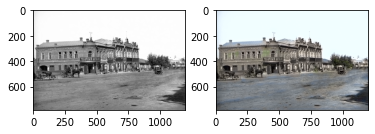

In [17]:
i = 'LG3'
img = Image.open('/content/drive/MyDrive/Colorization/' + str(i) + '.jpg')
image = img.resize((1200, 784))
imag = np.array(image)
size = imag.shape 
print(size)

if len(size) == 3:     #Эта часть использовалась на этапе обучения и определения параметров, чтобы сравнивать цветное исходное изображение и результат работы сети
    lab = rgb2lab(1.0/255*imag)                
    A, Y = lab[:,:,0], lab[:,:,1:]
    X = np.reshape((A), (1, size[0], size[1], 1))
    print(X.shape)

    output = model.predict(X)
    print(output.shape)
    output[:,:,:,0] = output[:,:,:,0] * std_a + mean_a
    output[:,:,:,1] = output[:,:,:,1] * std_b + mean_b

    min_vals, max_vals = -128, 127
    ab = np.clip(output[0], min_vals, max_vals)
    cur = np.zeros((size[0], size[1], 3))
    cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100)
    cur[:,:,1:] = ab
    rgb = lab2rgb(cur)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(rgb)


elif len(size) == 2:     #Эта часть используется для раскраски изначально чб изображений
    X = np.reshape((imag), (1, size[0], size[1], 1))
    X = X * 100.0 / 255.0
    print(X.shape)

    output = model.predict(X)
    print(output.shape)
    output[:,:,:,0] = output[:,:,:,0] * std_a + mean_a
    output[:,:,:,1] = output[:,:,:,1] * std_b + mean_b

    min_vals, max_vals = -128, 127
    ab = np.clip(output[0], min_vals, max_vals)
    cur = np.zeros((size[0], size[1], 3))
    cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100)
    cur[:,:,1:] = ab
    rgb = lab2rgb(cur)
    plt.subplot(1, 2, 1)
    plt.imshow(imag, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(rgb)

In [18]:
print(rgb.shape)
result = Image.fromarray((rgb * 255).astype(np.uint8))
result.save('/content/drive/MyDrive/Colorization/L3.jpg')

(784, 1200, 3)
